In [1]:
# Hands-On-Advanced-Deep-Learning-Time-Series-Forecasting-with-Tensors-Medium

## url
    # https://medium.com/@dave.cote.msc/hands-on-advanced-deep-learning-time-series-forecasting-with-tensors-7facae522f18

## article title
    # Hands-On Advanced Deep Learning Time Series Forecasting with Tensors

## article by
    # Dave Cote, M.Sc.

## published by
    # Medium

## dataset by
    # author

## publisher url
    # https://medium.com/

## github url
    # https://github.com/CoteDave/blog/blob/master/Hands-on%20Advanced%20Deep%20Learning%20Time%20Series%20Forecasting%20with%20Tensors/Advanced%20DL%20Forecasting%20-%20EASY.ipynb

## 1 Loading Data and Exploration

### 1.1 Environment Setup

In [2]:
# importing libraries
import os
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, RepeatVector, TimeDistributed
from keras.callbacks import Callback, EarlyStopping
from keras.utils.vis_utils import plot_model

from statsmodels.tsa.seasonal import seasonal_decompose

from mdn import MDN, get_mixture_loss_func, sample_from_output
from keras_multi_head import MultiHead, MultiHeadAttention
from keras_self_attention import SeqSelfAttention
from tcn import TCN

# importing custom libraries
from ts_transform import TransformerLog, TransformerDiff
from rdr_scorer import RdR_scorer

In [3]:
import random as python_random

seed_value = 10
# reset the seed values for respective libraries
def reset_seeds(value):
    os.environ['PYTHONHASHSEED']=str(value)
    python_random.seed(value)
    np.random.seed(value)
    tf.random.set_seed(value)
    tf.keras.utils.set_random_seed(value)

reset_seeds(seed_value)

### 1.2 Loading Dataset

In [4]:
ts_sequence = pd.read_csv('./datasets/raw/easy_ts.csv', sep=';')
ts_sequence['DATE'] = pd.to_datetime(ts_sequence['DATE'])

print('ts_sequence', ts_sequence.shape)
ts_original = ts_sequence.copy()

ts_sequence (223, 2)


In [5]:
# parameters for the dataset wrapped in a dictionary
# this is to ensure all the values to be used for this dataset & model building are in one place
dict_ts_sequence = {
    'dataset': ts_sequence, 
    'dataset_orig' : ts_sequence,
    'ts_original': ts_original.copy(),
    'stabilize_variance': False,
    'stabilize_mean': False,
    'seasonal_features': True,
    'diff_trend': False,
    'exog': False,
    'fourier_terms': False,
    
    'date_colname': 'DATE', # name of the date column
    'y_colname': 'EASY', # name of the target column
    'n_lags': 16, # use 16 previous periods to ...
    'n_leads': 24, # ... predict 24 periods ahead
    'freq': 12 # no. of periods in a year
    # (frequency -> 4=quarterly, 12=monthly, 52=weekly, 365=daily)
}

### 1.3 Dataset Exploration

In [6]:
def explore_time_series(data, date_colname, y_colname, exogenous=False):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data[date_colname], data[y_colname])
    plt.title('Time Series Plot')
    plt.show()
    
    if exogenous == True:
        fig, ax = plt.subplots(figsize=(18, 9))
        print('Exogenous Features - Multivariate')
        plt.title('Exogenous Time Series - Multivariate')
        for col in data.columns.difference([date_colname, 'Date', 'date']):
            print(col)
            if col == y_colname:
                ax.plot(data[date_colname], np.log1p(data[col]), linewidth=3)
            else:
                ax.plot(data[date_colname], np.log1p(data[col]), linewidth=1, alpha=0.6)

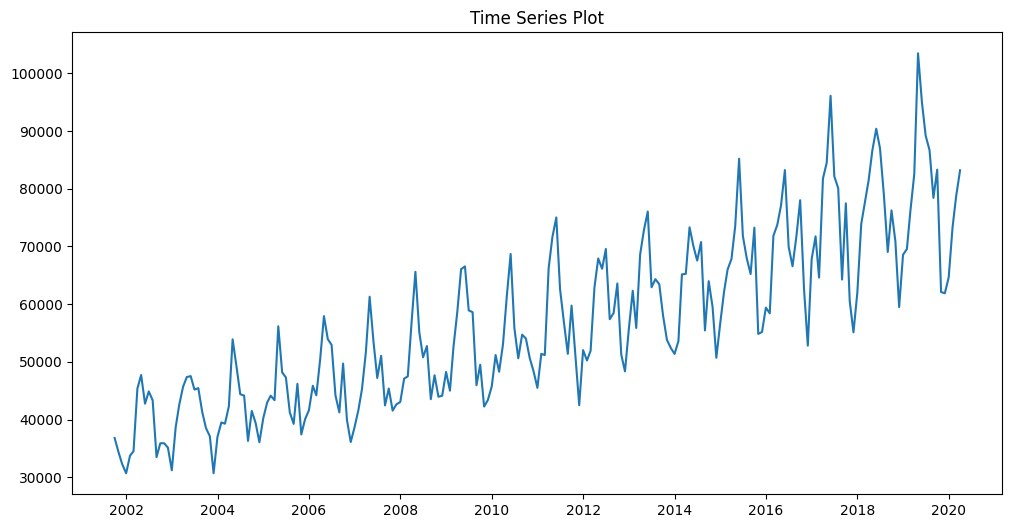

In [7]:
explore_time_series(dict_ts_sequence['dataset'],
                    dict_ts_sequence['date_colname'],
                    dict_ts_sequence['y_colname'])

This time series plot tells us the time series is deterministic and follows a strong upward trend. However, there are some seasonality patterns that we can see in the plot. Every year, there are spikes at around the first quarter of the year. Following the spike, we can see a trough at mid-year, and another spike for the last quarter of the year. This is a typical pattern for a time series that has a yearly seasonality with a strong upward trend.  
  
We can check the seasonal decomposition plot to confirm the seasonality pattern. The seasonal decomposition plot shows the trend, seasonality, and residual components of the time series.

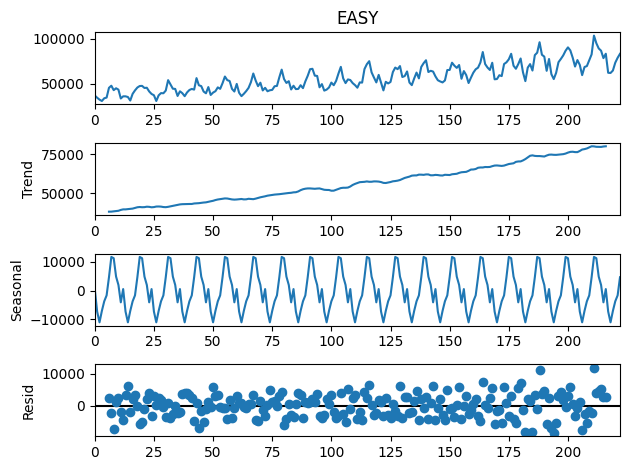

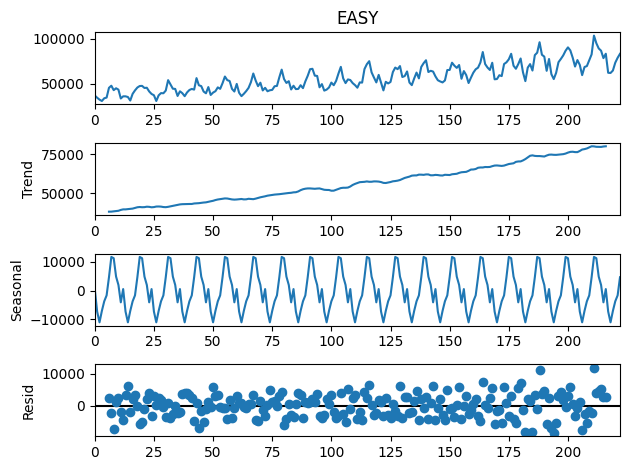

In [8]:
result = seasonal_decompose(ts_sequence[dict_ts_sequence['y_colname']], model='additive', period = dict_ts_sequence['freq'])
result.plot()

## 2 Feature Engineering

### 2.1 Train Test Split function

In [9]:
def split_ts_train_test(ts,
                        date_colname,
                        y_colname_list,
                        n_leads):
    
    ts_train = ts.iloc[:-n_leads, :]
    ts_test = ts.iloc[-n_leads:, :]
       
    return ts, ts_train, ts_test

### 2.2 Feature Extraction - Seasonal Means
We need to calculate the seasonal means for the features.

In [10]:
def seasonal_means_extract(dataset, date_colname, y_colname, n_leads, freq, y_scaler_sequence = None):
    """Calculate the seasonal means of a given time serie

    Args:
        dataset (dataframe): pandas dataframe
        date_colname (str): Name of the date column in the given dataframe
        y_colname (str): Name of the time serie column in the given dataframe
        n_leads (int): number of period to forecast into the futur
        freq (int): frequency, periods of the time series (1=yearly, 12=monthly, 52=weekly, 365=daily)

    Returns:
        list: a list of strings representing the header columns
    """
    keep_cols = list(dataset.columns)
    
    timeserie = dataset[[date_colname, y_colname]].copy()
    if y_scaler_sequence != None:
        timeserie[y_colname] = y_scaler_sequence.inverse_transform(timeserie[[y_colname]]).ravel()
    
    timeserie.index.name = 'index'
    timeserie.index = pd.to_datetime(timeserie[date_colname])
    timeserie.index.name = 'index'
    
    min_year = np.min(timeserie.index.year)
    max_year = np.max(timeserie.index.year) + int(n_leads/freq) + 5

    all_dates = pd.DataFrame(pd.date_range(pd.to_datetime(str(min_year) + '-01-01'),
                  pd.to_datetime(str(max_year) + '-12-31')-timedelta(days=1),freq='d'), columns = ['ds'])

    if freq == 12:

        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter

        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']

        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
    elif freq == 4:    
        timeserie['QUARTER'] = timeserie.index.quarter.astype(str)
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['QUARTER_YEAR'] = timeserie['YEAR'] + '_' + timeserie['QUARTER']

        all_dates['QUARTER'] = all_dates['ds'].dt.quarter.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['QUARTER_YEAR'] = all_dates['YEAR'] + '_' + all_dates['QUARTER']
        all_dates = all_dates.groupby(['QUARTER_YEAR']).size().reset_index()
        all_dates.columns = ['QUARTER_YEAR', 'N_DAYS']
        

        timeserie1 = pd.merge(timeserie, quarter_mean, how = 'left', 
                              left_on = 'QUARTER', right_on = 'QUARTER')
        timeserie1.index = timeserie.index


    elif freq == 52:   
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['WEEK_YEAR'] = timeserie['YEAR'].astype(str) + '_' + timeserie['WEEK'].astype(str)
        #del timeserie['YEAR']

        all_dates['WEEK'] = all_dates['ds'].dt.week.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['WEEK_YEAR'] = all_dates['YEAR'] + '_' + all_dates['WEEK']
        all_dates = all_dates.groupby(['WEEK_YEAR']).size().reset_index()
        all_dates.columns = ['WEEK_YEAR', 'N_DAYS']

        #del timeserie['WEEK_YEAR']


        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
    
    elif freq >= 100 and freq <= 600:    
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH'] = timeserie.index.month
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie = timeserie.fillna(0)
     
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        model_mean = timeserie[['WEEKLY_MONTHLY', y_colname]].groupby(['WEEKLY_MONTHLY']).mean([y_colname]).reset_index()
        model_mean.columns = ['WEEKLY_MONTHLY', 'WEEKLY_MONTHLY_MEAN']
        timeserie = pd.merge(timeserie, model_mean, how = 'left', left_on = 'WEEKLY_MONTHLY', right_on = 'WEEKLY_MONTHLY')
        #del timeserie2['MEAN_MODEL']
    
    timeserie.index = pd.to_datetime(dataset[date_colname])
    
    if y_scaler_sequence != None:
        for col in [col for col in timeserie.columns if '_MEAN' in col]:
            timeserie[col] = y_scaler_sequence.transform(timeserie[[col]]).ravel()
    
    add_cols = list(set(keep_cols) - set(timeserie.columns))
    
    for col in add_cols:
        
        timeserie[col] = dataset[col]

    return timeserie

SEASONALITIES


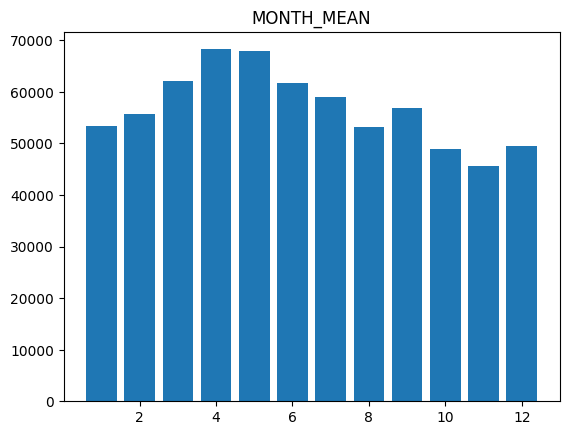

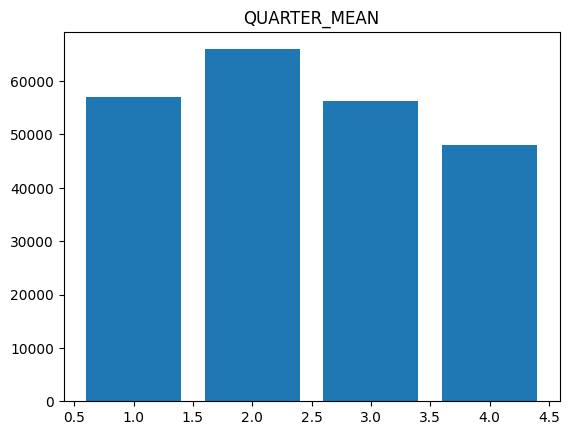

In [11]:
#for key, value in dict_ts.items():
mean_df = seasonal_means_extract(dataset = dict_ts_sequence['dataset'], 
                                 date_colname = dict_ts_sequence['date_colname'], 
                                 y_colname= dict_ts_sequence['y_colname'], 
                                 n_leads= dict_ts_sequence['n_leads'], 
                                 freq= dict_ts_sequence['freq'])
if dict_ts_sequence['freq'] == 12:
    print('SEASONALITIES')
    mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
    plt.title('MONTH_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
    plt.title('QUARTER_MEAN')
    plt.show()
else:
    print('SEASONALITIES')
    
    mean_df_distinct = mean_df[['DAY_OF_WEEK','DAY_OF_WEEK_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['DAY_OF_WEEK'], mean_df_distinct['DAY_OF_WEEK_MEAN'])
    plt.title('DAY_OF_WEEK_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['WEEK','WEEK_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['WEEK'], mean_df_distinct['WEEK_MEAN'])
    plt.title('WEEK_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
    plt.title('MONTH_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
    plt.title('QUARTER_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['WEEKLY_MONTHLY','WEEKLY_MONTHLY_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['WEEKLY_MONTHLY'], mean_df_distinct['WEEKLY_MONTHLY_MEAN'])
    plt.title('WEEKLY_MONTH_MEAN')
    plt.show()
    

In [12]:
### This function will be usefull to merge the seasonal means ont he final dataset
def merge_seasonal_features(dataset, seasonal_features):
    timeserie = dataset.copy()
    
    timeserie.index = pd.to_datetime(timeserie.index)

    timeserie.index.name = 'index'
    
    
    
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    timeserie['DAY_OF_MONTH'] = timeserie.index.day
    timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
    timeserie['WEEK'] = timeserie.index.week
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
    
    for feat in ['WEEK',
                 'MONTH',
                'QUARTER',
                'DAY_OF_MONTH',
                'DAY_OF_WEEK',
                'WEEKLY_MONTHLY']:
        if feat in seasonal_features.columns:
            seasonal_features_feat = seasonal_features[[feat, feat+'_MEAN']].drop_duplicates().reset_index(drop = True)
            timeserie = pd.merge(timeserie, seasonal_features_feat[[feat, feat+'_MEAN']], how = 'left', left_on = feat, right_on = feat)

            del timeserie[feat]
        else:
            try:
                del timeserie[feat]
            except:
                pass
            pass
    
    for col in timeserie.columns:
        dataset[col] = timeserie[col].values
    
    
    return dataset

### 2.3 Feature Extraction - Lag Features
In order to predict multiple steps ahead, it is imprtant to know that happened in the few steps before. We can use the lag features to capture the information from the past. Herem in our dataset, we are using the previous 14 periods to predict the next 24 periods. Therefore, the dimensions of each datapoint will shift from from 1D to 2D. From a vector to a matrix.

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, feat_str_at_end=True, feat_lag_str = 'TM', feat_lead_str = 'TP'):
    
    if feat_str_at_end == True:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          if i < 10:
              name_i = '0' + str(i)
          else:
              name_i = str(i)
              
          names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'') +'_' + feat_lag_str + name_i) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    else:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          names += [(feat_lag_str + '%d' % (i) + str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    return agg

Here, 'TM' means 'TIme Minus' and 'TP' means 'TIme Plus'. For example, TM1 means the value of the previous period, TM2 means the value of the period before the previous period, and so on. Now, we have a multi-target regression dataset.  
  
Now, we need to add the seasonal means to the lag features, so that the dataset becomes robust to the seasonality (in our dataset, the seasonality is yearly).

### 2.4 Feature Extraction - Fourier Terms

In [14]:
def extract_fourier_terms(dataset):
    
    #ts_copy = dataset[[date_colname]]
    dataset['sin365_2'] = np.sin(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['sin365_2'] = StandardScaler().fit_transform(dataset['sin365_2'].values.reshape(-1,1))
    
    dataset['sin365_4'] = np.sin(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['sin365_4'] = StandardScaler().fit_transform(dataset['sin365_4'].values.reshape(-1,1))
    
    dataset['cos365_2'] = np.cos(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['cos365_2'] = StandardScaler().fit_transform(dataset['cos365_2'].values.reshape(-1,1))
    
    dataset['cos365_4'] = np.cos(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['cos365_4'] = StandardScaler().fit_transform(dataset['cos365_4'].values.reshape(-1,1))
    
    dataset['tanh365_2'] = np.tanh(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['tanh365_2'] = StandardScaler().fit_transform(dataset['tanh365_2'].values.reshape(-1,1))
    
    dataset['tanh365_4'] = np.tanh(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['tanh365_4'] = StandardScaler().fit_transform(dataset['tanh365_4'].values.reshape(-1,1))
    
    return dataset

### 2.5 Merge Generated Features into a Final Dataset
We will merge the engineered features i.e. Seasonal Means, Lag Features, and Fourier Terms into a final dataset.

In [15]:
def dataprep_pipeline(ts_data, 
                      dict_ts_sequence, 
                      seasonal_features = True,
                      diff_trend = True,
                      exog = True,
                      fourier_terms = True):
    ####SCALING
    y_scaler_forecast = StandardScaler()
    ts_sequence_forecast = ts_data.copy()
    ts_sequence_forecast

    y_data = ts_sequence_forecast[[dict_ts_sequence['y_colname']]].copy()

    y_data = pd.DataFrame(y_scaler_forecast.fit_transform(y_data))
    y_data.columns = [dict_ts_sequence['y_colname']]
    for y_colname in y_data.columns:
        ts_sequence_forecast[y_colname] = y_data[y_colname].values

    y_colname = dict_ts_sequence['y_colname']
    ###CALCULATE SEASONAL MEANS
    if seasonal_features == True:
        seasonal_list = []
        all_cols = [dict_ts_sequence['date_colname'], dict_ts_sequence['y_colname']]

        ts_sequence_seasonal_feats_full = seasonal_means_extract(dataset = ts_data[all_cols], 
                                                         date_colname = dict_ts_sequence['date_colname'], 
                                                         y_colname= y_colname, 
                                                         n_leads= dict_ts_sequence['n_leads'], 
                                                         freq= dict_ts_sequence['freq'],
                                                          y_scaler_sequence = y_scaler_forecast)
        
        ts_sequence_seasonal_feats_full.index = pd.to_datetime(ts_data[dict_ts_sequence['date_colname']])
        del ts_sequence_seasonal_feats_full[dict_ts_sequence['date_colname']]
        del ts_sequence_seasonal_feats_full[y_colname]

    ts_sequence_forecast.index = pd.to_datetime(ts_sequence_forecast['DATE'])
    

    ts_sequence_supervised_full = series_to_supervised(ts_sequence_forecast[[y_colname]], 
                                              n_in=dict_ts_sequence['n_lags'], 
                                              n_out=1, 
                                              dropnan=True, 
                                              feat_str_at_end=True, 
                                              feat_lag_str = 'TM', 
                                              feat_lead_str = 'TP')
    
    ### MERGE SEASONAL MEANS
    if seasonal_features == True:
        ts_sequence_supervised_full = merge_seasonal_features(dataset = ts_sequence_supervised_full.copy(), 
                                                              seasonal_features = ts_sequence_seasonal_feats_full.copy())
        
        for col in ts_sequence_seasonal_feats_full.columns:
            if col in ts_sequence_supervised_full.columns:
                ts_sequence_supervised_full[col] = StandardScaler().fit_transform(ts_sequence_supervised_full[[col]]).ravel()

    ### DIFF TREND
    if diff_trend == True:

        ts_sequence_supervised_full['DIFF_' + y_colname] = StandardScaler().fit_transform(ts_sequence_supervised_full[y_colname].diff().fillna(0).values.reshape(-1,1))

        decomp = seasonal_decompose(ts_sequence_supervised_full[y_colname], model='additive', period = dict_ts_sequence['freq'], extrapolate_trend=1)
        ts_sequence_supervised_full['TREND_' + y_colname] = StandardScaler().fit_transform(decomp.trend.values.reshape(-1,1))
        #ts_sequence_supervised['SEASON'] = StandardScaler().fit_transform(decomp.seasonal.values.reshape(-1,1))

    ### EXOG
    if exog == True:
        exog_cols = []
        all_cols = [dict_ts_sequence['y_colname'], dict_ts_sequence['date_colname'], 'Date','date']
        for col in ts_sequence.columns.difference(all_cols):
            exog_cols.append(col)

        dict_ts_sequence_exog = ts_sequence[exog_cols]

        exog_scaler = StandardScaler()
        dict_ts_sequence_exog = pd.DataFrame(exog_scaler.fit_transform(dict_ts_sequence_exog),
                                             index = pd.to_datetime(ts_sequence[dict_ts_sequence['date_colname']]),
                                             columns = exog_cols)
        


        for col in dict_ts_sequence_exog.columns:
            ts_sequence_supervised_full = pd.merge(ts_sequence_supervised_full, 
                                                   dict_ts_sequence_exog[[col]],
                                                  how = 'left',
                                                  left_index = True,
                                                  right_index = True)
    
    return ts_sequence_supervised_full, y_scaler_forecast

In [16]:
ts_full, ts_sequence_train, ts_sequence_test = split_ts_train_test(ts = dict_ts_sequence['dataset_orig'].copy(),
                                                  date_colname = dict_ts_sequence['date_colname'],
                                                  y_colname_list = dict_ts_sequence['y_colname'],
                                                  n_leads = dict_ts_sequence['n_leads'])


diff_transformer_dict_train = {}
diff_transformer_dict_full = {}

log_transformer_dict_train = {}
log_transformer_dict_full = {}

y_colname =  dict_ts_sequence['y_colname']
log_transformer_full = TransformerLog()
diff_transformer_full = TransformerDiff()

if dict_ts_sequence['stabilize_variance'] == True:
    ts_full[y_colname] = log_transformer_full.fit_transform(ts_full[[y_colname]].values)
    log_transformer_dict_full[y_colname] = log_transformer_full
if dict_ts_sequence['stabilize_mean'] == True:
    ts_full[y_colname] = diff_transformer_full.fit_transform(ts_full[[y_colname]].values)
    diff_transformer_dict_full[y_colname] = diff_transformer_full
    
ts_full = ts_full.dropna()

log_transformer = TransformerLog()
diff_transformer = TransformerDiff()
if dict_ts_sequence['stabilize_variance'] == True:
    ts_sequence_train[y_colname] = log_transformer.fit_transform(ts_sequence_train[[y_colname]].values)
    log_transformer_dict_train[y_colname] = log_transformer
if dict_ts_sequence['stabilize_mean'] == True:
    ts_sequence_train[y_colname] = diff_transformer.fit_transform(ts_sequence_train[[y_colname]].values)
    diff_transformer_dict_train[y_colname] = diff_transformer
        
ts_sequence_train = ts_sequence_train.dropna()


dict_ts_sequence['diff_transformer_dict_full'] = diff_transformer_dict_full
dict_ts_sequence['log_transformer_dict_full'] = log_transformer_dict_full
ts_sequence_supervised_full, y_scaler_forecast = dataprep_pipeline(ts_full.copy(), 
                                                                  dict_ts_sequence, 
                                                                  seasonal_features = dict_ts_sequence['seasonal_features'],
                                                                  diff_trend = dict_ts_sequence['diff_trend'],
                                                                  exog = dict_ts_sequence['exog'],
                                                                  fourier_terms = dict_ts_sequence['fourier_terms'])

dict_ts_sequence['diff_transformer_dict_train'] = diff_transformer_dict_train
dict_ts_sequence['log_transformer_dict_train'] = log_transformer_dict_train
ts_sequence_supervised, y_scaler_sequence = dataprep_pipeline(ts_sequence_train.copy(), 
                                                              dict_ts_sequence, 
                                                              seasonal_features = dict_ts_sequence['seasonal_features'],
                                                              diff_trend = dict_ts_sequence['diff_trend'],
                                                              exog = dict_ts_sequence['exog'],
                                                              fourier_terms = dict_ts_sequence['fourier_terms'])

In [17]:
ts_sequence_supervised.columns

Index(['EASY_TM16', 'EASY_TM15', 'EASY_TM14', 'EASY_TM13', 'EASY_TM12',
       'EASY_TM11', 'EASY_TM10', 'EASY_TM09', 'EASY_TM08', 'EASY_TM07',
       'EASY_TM06', 'EASY_TM05', 'EASY_TM04', 'EASY_TM03', 'EASY_TM02',
       'EASY_TM01', 'EASY', 'MONTH_MEAN', 'QUARTER_MEAN'],
      dtype='object')

In [18]:
ts_sequence_supervised.head(1).T

DATE,2003-01-31
EASY_TM16,-1.326273
EASY_TM15,-1.513817
EASY_TM14,-1.675855
EASY_TM13,-1.794749
EASY_TM12,-1.561171
EASY_TM11,-1.502261
EASY_TM10,-0.669839
EASY_TM09,-0.490234
EASY_TM08,-0.870604
EASY_TM07,-0.707810


### 3 Convert Dataset from 2D Matrices to 3D Tensors

In [19]:
def prep_data_3d_arch1(data, y_colname_list, date_colname, n_leads):
    n_step = n_leads
    
    timeseries = data.copy()
    timeseries = timeseries[timeseries.columns.difference([date_colname])]
    
    xtimeseries = timeseries[timeseries.columns.difference([date_colname])]
    ytimeseries = timeseries[y_colname_list]
    
    feats = list(xtimeseries.columns)
    xlist = []
    ylist = []
    
    i=0
    for i in range(0, len(timeseries) - ((n_step*2)-1)):
        xlist.append([xtimeseries.iloc[i:i+n_step].values])
        ylist.append([ytimeseries.iloc[i+n_step:i+(n_step*2)][y_colname_list].values])
        
    xlist_T = np.array(xlist).reshape(len(xtimeseries)-((n_step*2)-1), n_step, len(xtimeseries.columns))
    ylist_T = np.array(ylist).reshape(len(ytimeseries)-((n_step*2)-1), n_step, len(y_colname_list))

    xlistTest = []
    i = 0
    for i in range(len(xtimeseries)-n_step, len(xtimeseries)-(n_step-1)):
        xlistTest.append([xtimeseries.iloc[i:i+n_step].values])
        
    xlistTest_T = np.array(xlistTest).reshape(1, n_step, len(xtimeseries.columns))

    xlist_T_all = xlist_T.copy()
    ylist_T_all = ylist_T.copy()
    xlistTest_T_all = xlistTest_T.copy()
    
    return xlist_T_all, ylist_T_all, xlistTest_T_all, feats

### 3.1 3D Train Test Split

In [20]:
x_train_sequence, y_train_sequence, x_test_sequence, feats = prep_data_3d_arch1(data=ts_sequence_supervised.copy(),
                                                                                y_colname_list=[dict_ts_sequence['y_colname']],
                                                                                date_colname=dict_ts_sequence['date_colname'],
                                                                                n_leads=dict_ts_sequence['n_leads'])

In [21]:
print(x_train_sequence.shape, y_train_sequence.shape)

dict_explain_tensor = {}
ijk = 0 
for val in x_train_sequence.shape:
    if ijk == 0:
        dict_explain_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_tensor[val])
    ijk += 1

(136, 24, 19) (136, 24, 1)
136 Number of rows (Time occurences)
24 Sequence length - Number of steps to forecasts (n_leads)
19 Number of columns (Features)


In [22]:
print(x_test_sequence.shape)

(1, 24, 19)


### 3.2 3D Forecasting Dataset

In [23]:
x_train_full, y_train_full, x_forecast, feats = prep_data_3d_arch1(data = ts_sequence_supervised_full.copy(),
                                                                    y_colname_list = [dict_ts_sequence['y_colname']],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])

In [24]:
print(x_train_full.shape, y_train_full.shape)
dict_explain_full_tensor = {}
ijk = 0 
for val in x_train_full.shape:
    if ijk == 0:
        dict_explain_full_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_full_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_full_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_full_tensor[val])
    ijk += 1

(160, 24, 19) (160, 24, 1)
160 Number of rows (Time occurences)
24 Sequence length - Number of steps to forecasts (n_leads)
19 Number of columns (Features)


## 4 Performance Metrics (RdR Score)
The proposed RdR metric use: <br>
R: Naïve Random Walk <br>
d: Dynamic Time Warping <br>
R: Root Mean Squared Error <br>

The proposed RdR score technic will mainly answer three questions: <br>
#1 How can we take into account the shape similarity of a time series? : <br>
Answer: Dynamic Time Warping <br>

#2 How can we know if we should use our forecasting model or not? : <br>
Answer: Is it better or worst than a Naïve Random Walk? How Much ? (Well... also depends on your business goals here !) <br>

#3 How can we take into account the errors? : <br>
Answer: Root Mean Squared Error (RMSE) <br> 

0 = Performance same as a random walk model <br>
1 = Performance is perfect <br>
< 0 = Performance is worst than a random walk model <br>

Further reading: <br>
<https://medium.com/@dave.cote.msc/rdr-score-metric-for-evaluating-time-series-forecasting-models-1c23f92f80e7>

In [25]:
scorer_benchmark = RdR_scorer()

## 5 Bidirectional LSTM Model

In [26]:
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('.', end='')

### 5.1 BiLSTM Architecture

In [27]:
input_dim = int(x_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def create_BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=input_dim,
                                 return_sequences=False,
                                 kernel_initializer='glorot_uniform',
                                 activation='tanh',
                                 )))
    model.add(Dense(output_dim, activation='linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    
    return model

model = create_BiLSTM()    

### 5.2 BiLSTM Model Training

In [28]:
monitor_label = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=10)
history = model.fit(x_train_sequence, y_train_sequence,
                    epochs=1000,
                    batch_size=60,
                    validation_data=(x_train_full[-dict_ts_sequence['n_leads']:, :, :],
                                     y_train_full[-dict_ts_sequence['n_leads']:, :, :]),
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

...

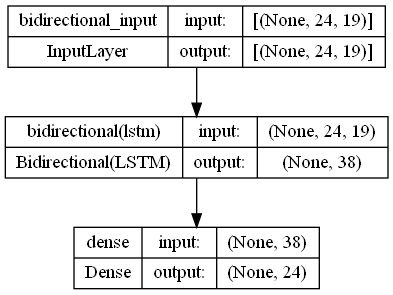

In [29]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [30]:
def plot_learning_curve(history, monitor_label='val_loss'):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    min_vec = []
    for i in range(len(hist)):
        if i == 0:
            min_vec.append(hist[[monitor_label]].iloc[i, :].values[0])
        else:
            if hist[[monitor_label]].iloc[i, :].values[0] < np.min(min_vec):
                min_vec.append(hist[[monitor_label]].iloc[i, :].values[0])
            else:
                min_vec.append(np.min(min_vec))
    
    hist['best_from_start'] = min_vec
    hist['improved'] = np.where(hist['best_from_start'] == hist[monitor_label], 1, 0)
    
    best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
    
    plt.figure(figsize=(18, 9))
    plt.plot(hist[monitor_label], label=monitor_label)
    
    try:
        plt.plot(hist['loss'], label='loss')
    except:
        pass
    
    plt.scatter(hist[hist['improved'] == 1]['epoch'], hist[hist['improved'] == 1][monitor_label], color='green', label='improved')
    plt.legend()
    plt.title('Learning curve'
              '\n' + 'best epoch:' + str(best_epoch) + '(' + str(round(np.min(hist[monitor_label]), 3)) + ')')

Max epoch: 257
Best epoch: 247


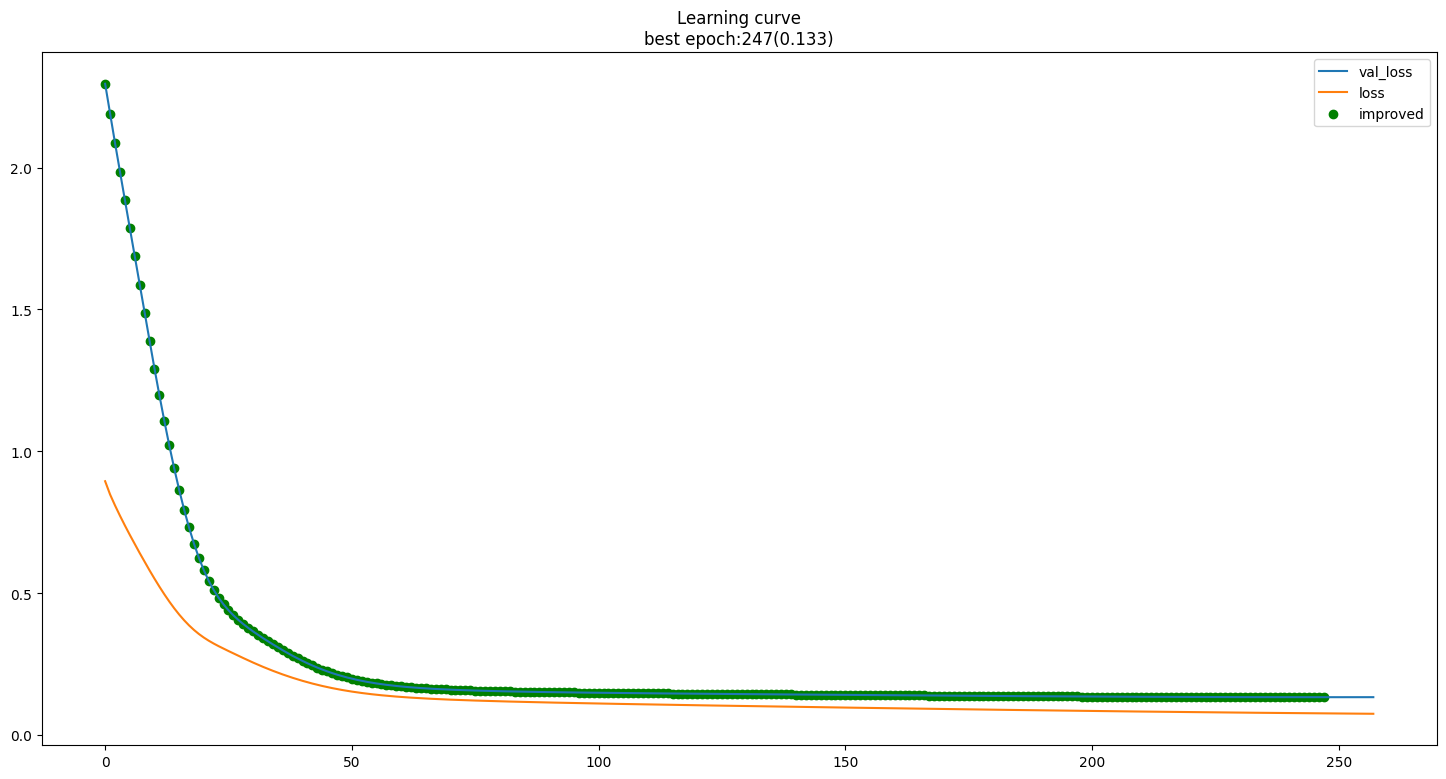

In [31]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Max epoch:', max_epoch)
print('Best epoch:', best_epoch)

### 5.3 BiLSTM Model Validation

In [32]:
pred_all = pd.DataFrame(model.predict(x_test_sequence)).T

1/1 [==============================] - 1s 952ms/step


In [33]:
def inverse_forecast(y_scaler, dict_ts, pred_df):
    pred_df = pd.DataFrame(y_scaler.inverse_transform(pred_df))
    pred_df.columns = ['Y_PRED']
    
    if dict_ts_sequence['stabilize_mean'] == True:
        pred_df['Y_PRED'] = dict_ts_sequence['diff_transformer_dict_train'][dict_ts['y_colname']].forecast_transform(pred_df[['Y_PRED']].values)
    if dict_ts_sequence['stabilize_variance'] == True:
        pred_df['Y_PRED'] = dict_ts_sequence['log_transformer_dict_train'][dict_ts['y_colname']].inverse_transform(pred_df[['Y_PRED']].values)
 
    return pred_df

In [34]:
def get_feat_for_scoring(ts, y_scaler, dict_ts, pred_df, model_name):
    
    ts_orig = y_scaler.inverse_transform(ts[dict_ts['y_colname']].values.reshape(-1,1))
    ts_orig = pd.DataFrame(ts_orig, index = ts.index, columns = [dict_ts['y_colname']])
    
    pred_df = inverse_forecast(y_scaler, dict_ts, pred_df)

    y_colname = dict_ts['y_colname']
    n_steps = dict_ts['n_leads']

    y_true = ts.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values.reshape(-1,1)
    y_true = pd.DataFrame(y_true, index = pd.to_datetime(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), columns = [dict_ts['y_colname']])
    
    y_pred = pred_df.copy()
    y_pred = pd.DataFrame(y_pred.values.ravel(), index = pd.to_datetime(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), columns = ['Y_PRED'])

    freq = dict_ts['freq']    
  
    return ts, y_colname, n_steps, y_true, y_pred, model_name, freq

In [35]:
ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'BiLSTM')

average_ensemble_model = []
average_ensemble_model.append(y_pred)

In [36]:
scorer_benchmark.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)

1970-02-28 00:00:00.000000222 1972-01-31 00:00:00.000000222


c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)


In [37]:
scorer_benchmark.get_df_viz()

,DTW,RMSE,RdR_SCORE,MODEL_NAME
0,23883.334510,6268.529777,0.538128,BiLSTM
1,59099.430044,12063.620641,0.000000,RandomWalk


In [38]:
print(scorer_benchmark.get_rdr_interpretation())

GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 53.81% better than a naïve random decision. The mean forecast accuracy is 91.82% (around 89.46% and 93.94% of accuracy per forecasted datapoint)


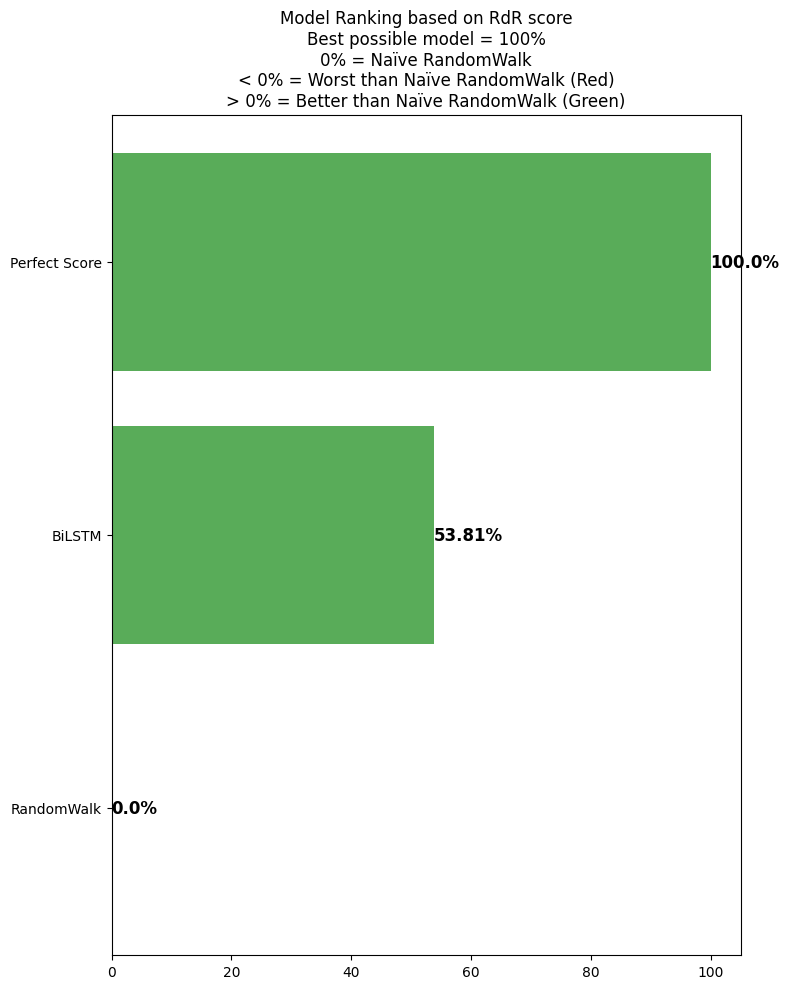

In [39]:
scorer_benchmark.plot_rdr_rank()

In [40]:
def get_pred_dates(freq, X_pred, date_colname, n_leads):
    #ts_sequence_train.index = pd.to_datetime(ts_sequence_train[date_colname])
    if freq == 12:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
    
    elif freq == 52:
        print(X_pred.index)
        print(max(X_pred.index))
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(weeks=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(weeks=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 4:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=3)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i*3) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
    
    elif freq == 2:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=6)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i*6) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 1:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(years=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq >= 250 and freq <= 368:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(days=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(days=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 1638:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=60)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*60) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 3276:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=30) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*30) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
    
    elif freq == 6552:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=15) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*15)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 9828:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=10)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*10)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 19656:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=5)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*5)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 98280:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=1)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    return X_pred_date

In [41]:
def plot_results(ts_train, ts_full, pred_df, y_scaler, forecast, y_scaler_forecast, dict_ts):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(pd.to_datetime(ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['date_colname']]),
            ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['y_colname']].values, label='PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),
            pred_df.values.ravel(), label='PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
            ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values, label = 'TRUE_TEST')
    plt.title('Validation: True vs MultiStep Forecast')
    plt.legend()

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
        pred_df.values.ravel())
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
        ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values)
    plt.title('Validation (Zoomed): True vs MultiStep Forecast')
    plt.legend()

    fig, ax = plt.subplots(figsize = (12,8))
    #ax.plot(pd.to_datetime(ts_train.index), 
            #ts_train[dict_ts['y_colname']].values.reshape(-1,1))
    ax.plot(pd.to_datetime(ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['date_colname']]),  
            ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['y_colname']].values, label = 'HISTORICAL')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
            pred_df.values.ravel(), label = 'PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
            ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values, label = 'TRUE_TEST')
    ax.plot(forecast.index, 
            forecast['Y_PRED'].values.ravel(), label = 'FORECAST')
    plt.title('MultiStep Forecast - ' + model_name)
    plt.legend()

### 5.4 BiLSTM Model Forecasting

In [42]:
monitor_label = 'loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=100)

model = create_BiLSTM()

history = model.fit(x_train_full,
                    y_train_full,
                    epochs=best_epoch*2,
                    batch_size=100,
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

pred_fscaled = pd.DataFrame(model.predict(x_forecast))
pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] = pred_forecast[col].astype(float)
    
ts_sequence_train.index = pd.to_datetime(ts_sequence_train[dict_ts_sequence['date_colname']])
ts_sequence.index = pd.to_datetime(ts_sequence[dict_ts_sequence['date_colname']])

x_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = x_pred_date.index

average_ensemble_model_forecast = []
average_ensemble_model_forecast.append(pred_forecast)

1/1 [==============================] - 1s 1s/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


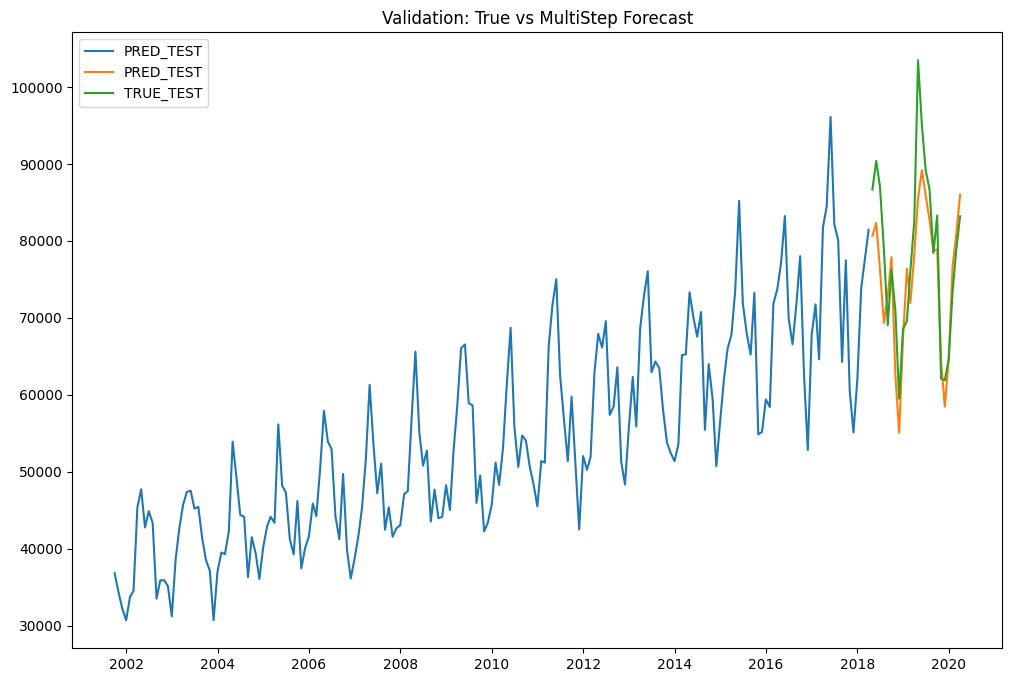

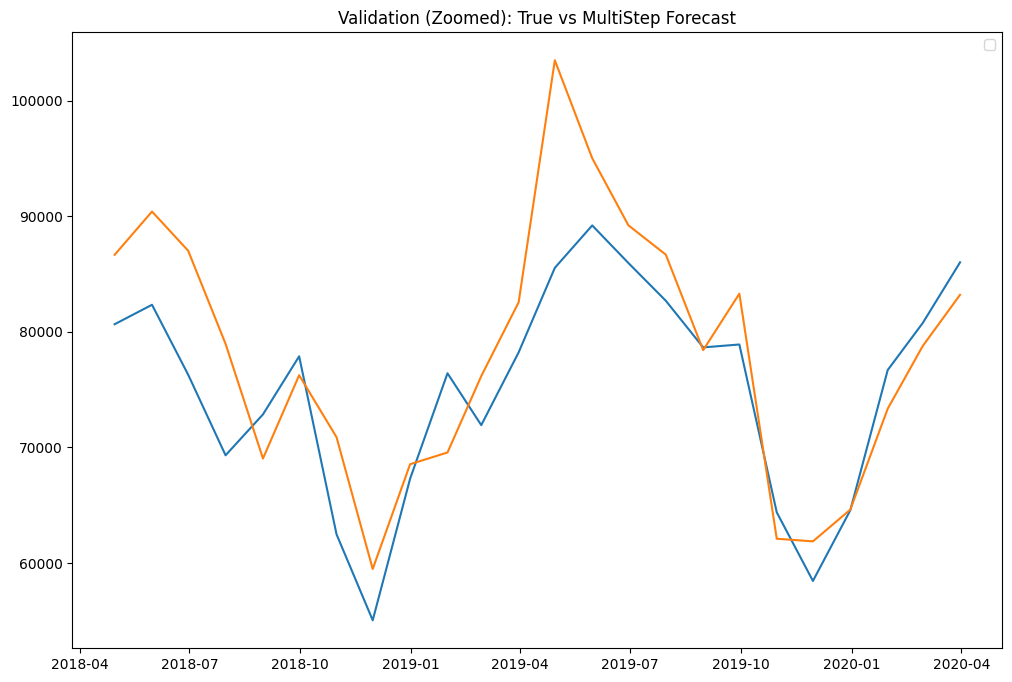

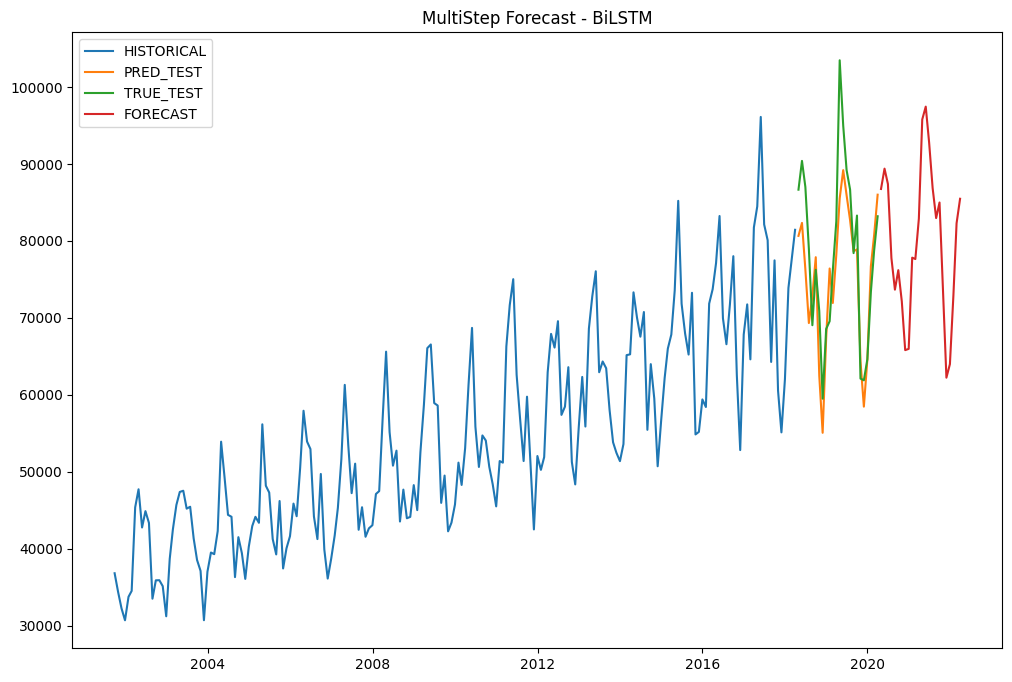

In [43]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

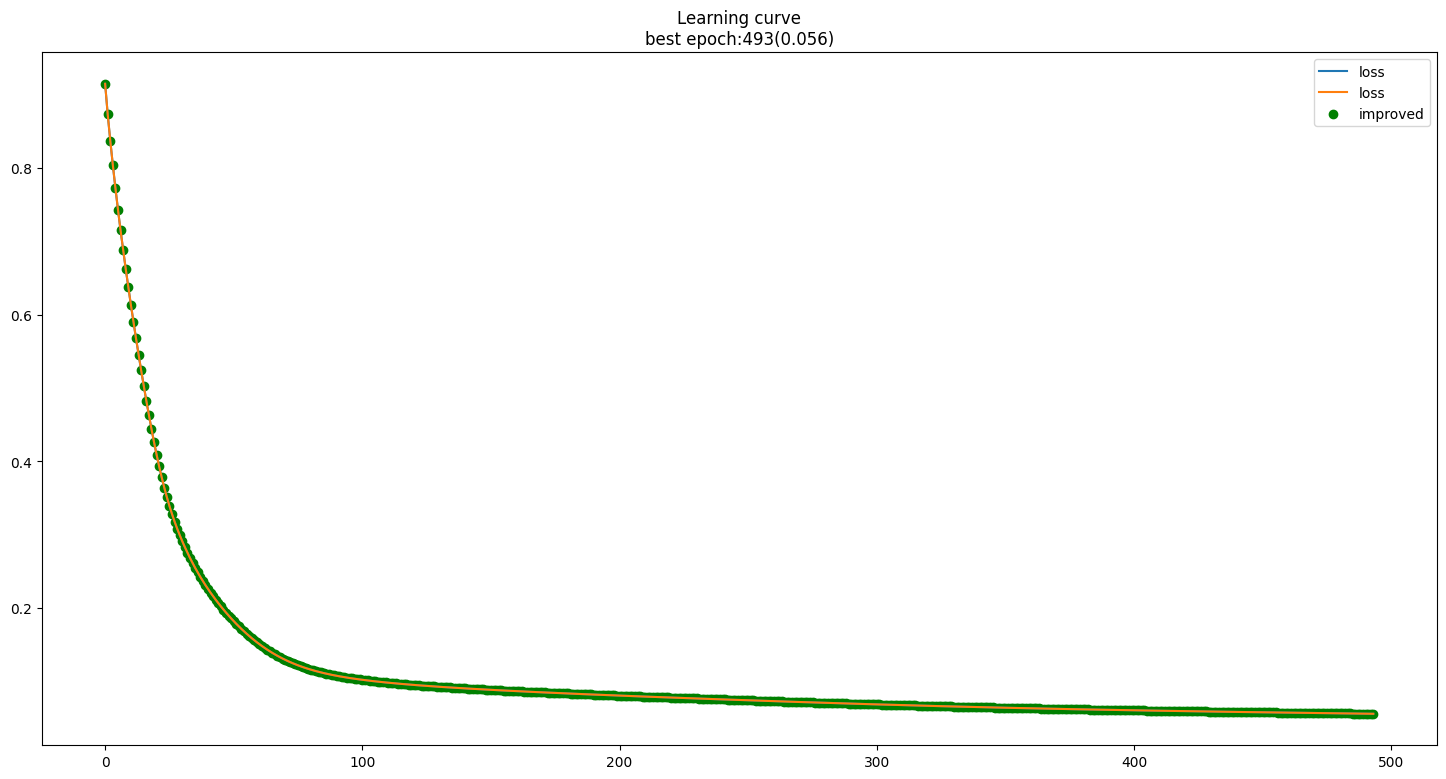

In [44]:
plot_learning_curve(history, monitor_label='loss')

## 6 Seq2Seq Model

### 6.1 Seq2Seq Architecture
Seq2seq Model is a combination of two models: Encoder and Decoder. The encoder model takes the input sequence and converts it into a vector. The decoder model takes the vector from the encoder and converts it into the output sequence. Seq2seq is mainly used to transform one sequence to another sequence i.e. time-series forecasting, machine translation, or text summarization can be some of the proper use cases of seq2seq.

In [45]:
input_dim = int(x_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])
n_samples = len(x_train_sequence)

def create_seq2seq():
    model = Sequential()
    
    # Encoder (first LSTM layer)
    model.add(LSTM(units=input_dim, return_sequences=False, activation = 'tanh'))
    model.add(Dense(150, activation="relu"))
    
    # using RepeatVector to copy N copies of Encoder output (last time step) as Decoder N inputs
    model.add(RepeatVector(output_dim))
    
    # Decoder (second LSTM layer)
    model.add(LSTM(units=input_dim, activation = 'tanh', return_sequences=True))
    
    # TimeDistributed layer to ensure consistency betweeb Dense Layer and Decoder LSTM layer
    model.add(TimeDistributed(Dense(output_dim, activation="linear")))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    
    return model

model = create_seq2seq()

### 6.2 Seq2Seq Model Training

In [46]:
monitor_label = 'val_loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(x_train_sequence,
                    y_train_sequence,
                    epochs=1000,
                    batch_size=24,
                    validation_data=(x_train_full[-24:, :, :],
                                     y_train_full[-24:, :, :]),
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

.....

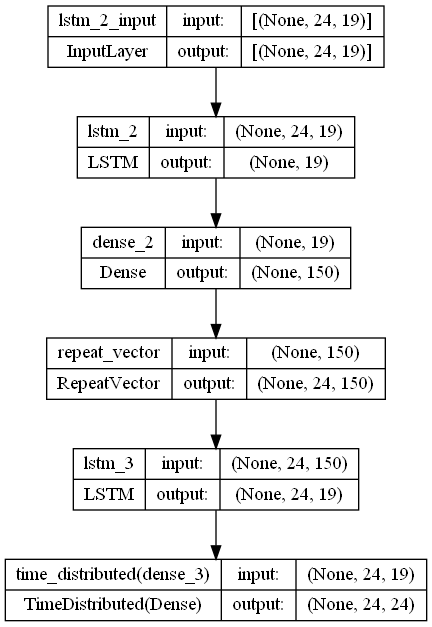

In [47]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 417


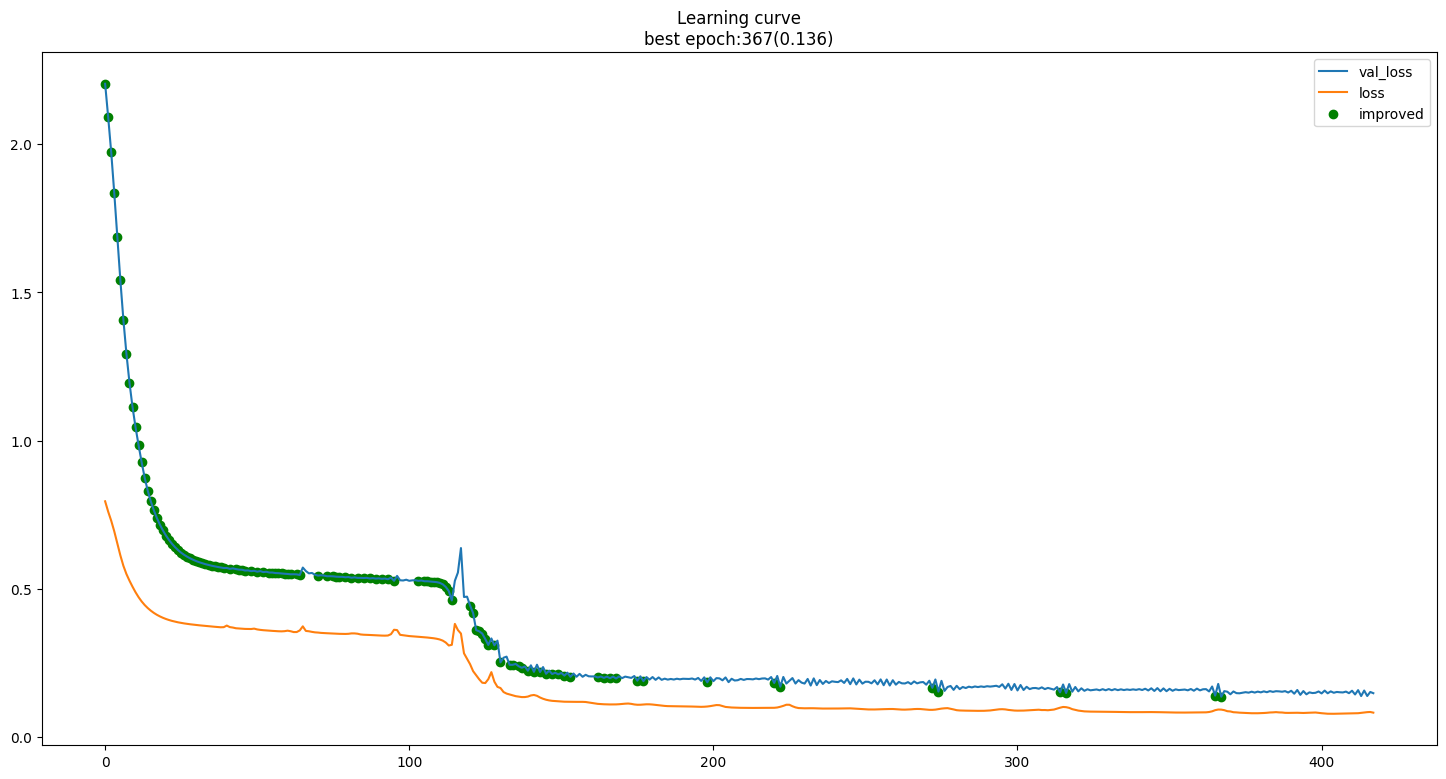

In [48]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

### 6.3 Seq2Seq Model Validation

In [49]:
pred_scaled = pd.DataFrame(model.predict(x_test_sequence)[0, :].T)
pred_all = pd.DataFrame(np.mean(pred_scaled.T, axis=1))
pred_all.columns = ['Y_PRED']

1/1 [==============================] - 1s 989ms/step


In [50]:
scorer_seq2seq = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts=ts_sequence.copy(),
                                                                                     y_scaler=y_scaler_sequence,
                                                                                     dict_ts=dict_ts_sequence.copy(),
                                                                                     pred_df=pred_all.copy(),
                                                                                     model_name='Seq2Seq')
average_ensemble_model.append(y_pred)

scorer_seq2seq.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name=model_name, freq=freq)
scorer_benchmark.add_rdr(scorer_seq2seq)

2020-04-30 00:00:00 2022-03-31 00:00:00


c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


,DTW,RMSE,RdR_SCORE,MODEL_NAME
0,23883.334510,6268.529777,0.538128,BiLSTM
1,59099.430044,12063.620641,0.000000,RandomWalk
2,30720.000799,7148.716437,0.443807,Seq2Seq


In [51]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 53.81% better than a naïve random decision. The mean forecast accuracy is 91.82% (around 89.46% and 93.94% of accuracy per forecasted datapoint)'

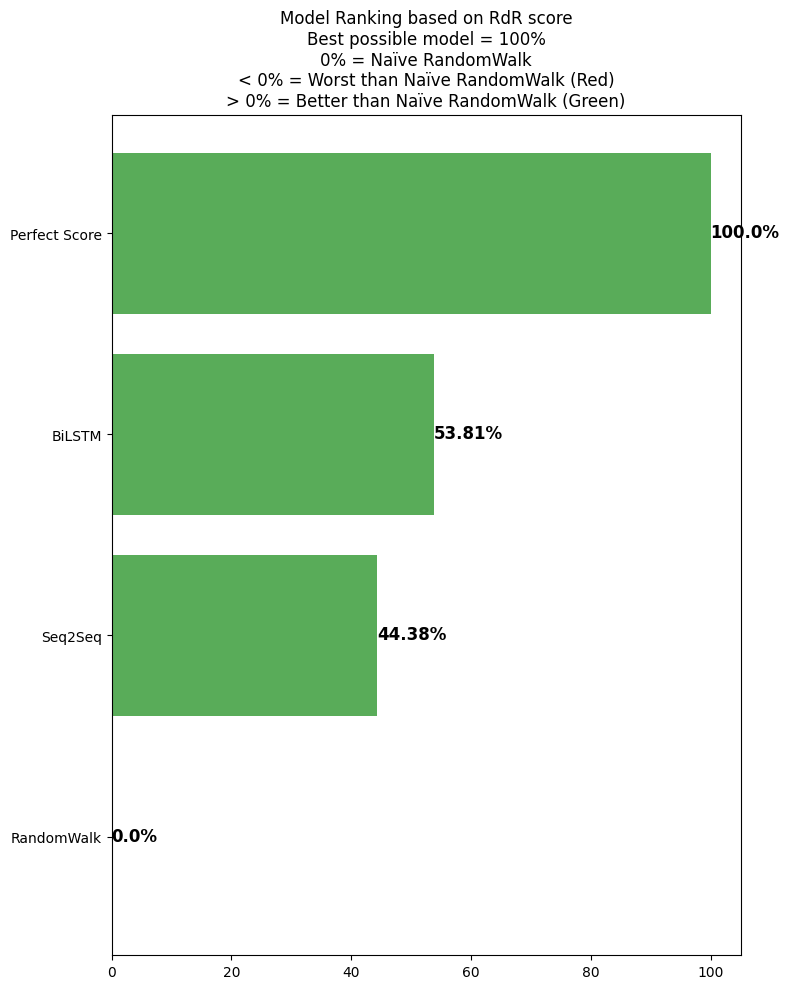

In [52]:
scorer_benchmark.plot_rdr_rank()

### 6.4 Seq2Seq Model Forecasting

In [53]:
monitor_label = 'loss'
early_stopping = EarlyStopping(monitor=monitor_label, patience=25)

model = create_seq2seq()

history = model.fit(x_train_full,
                    y_train_full,
                    epochs=best_epoch*2,
                    batch_size=24,
                    shuffle=False,
                    verbose=0,
                    callbacks=[early_stopping, PrintDot()])

pred_fscaled = pd.DataFrame(model.predict(x_forecast)[0, :].T)
pred_forecast = pd.DataFrame(np.mean(pred_fscaled.T, axis=1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] = pred_forecast[col].astype(float)

x_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = x_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

1/1 [==============================] - 1s 987ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


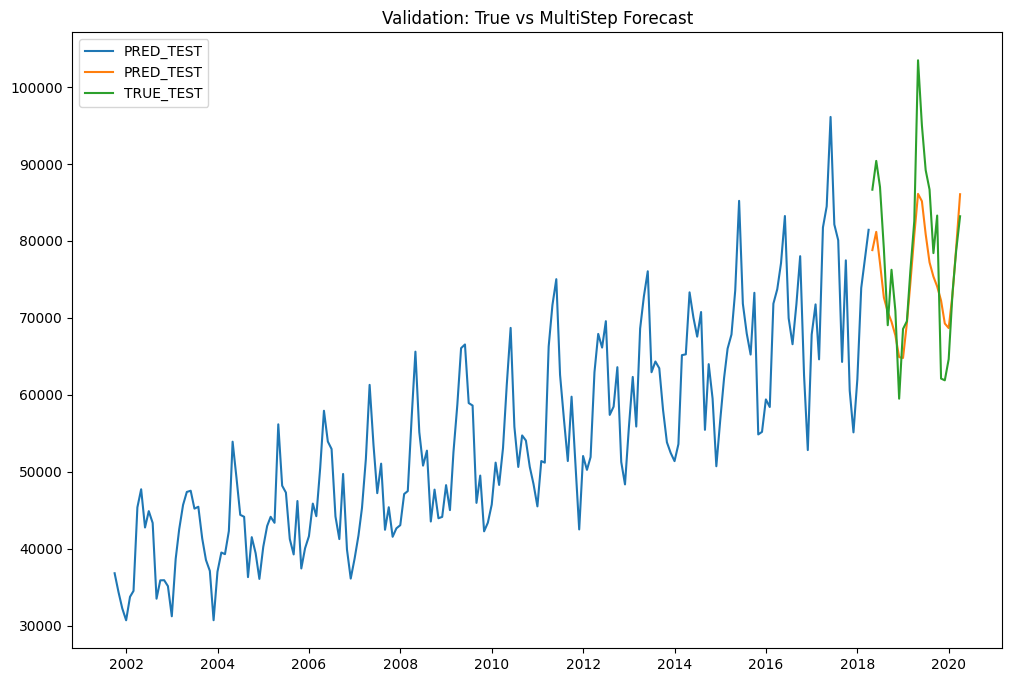

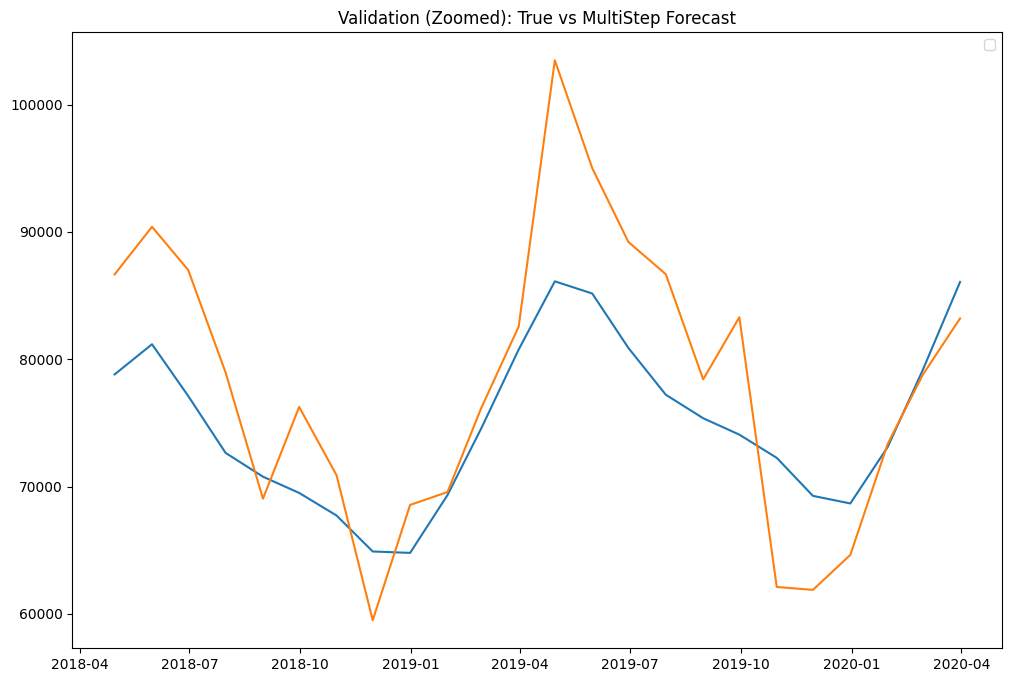

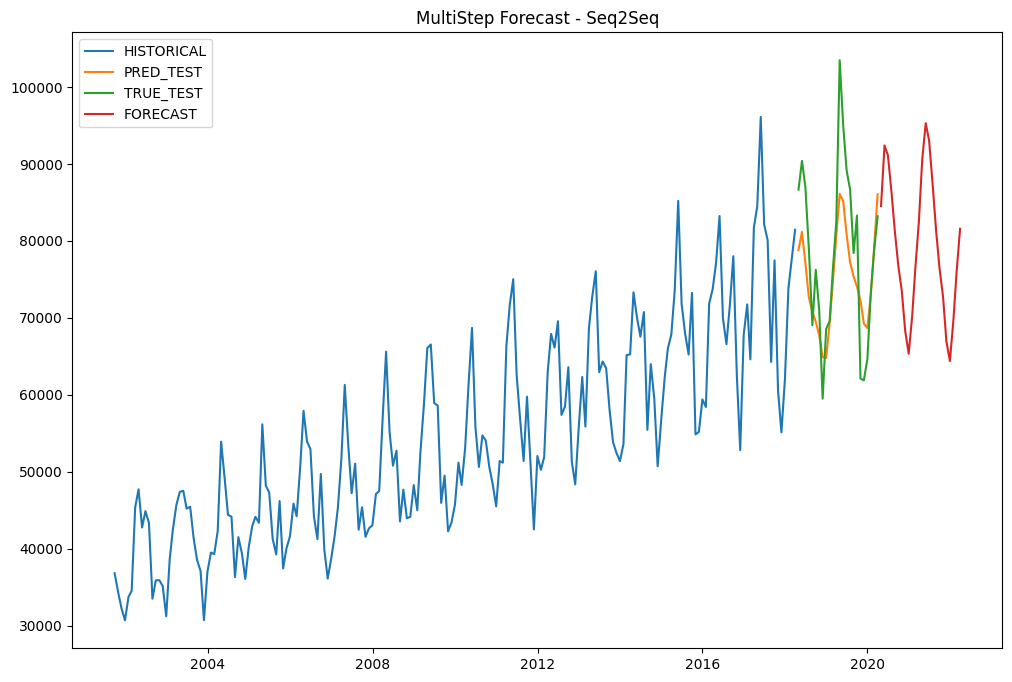

In [54]:
plot_results(ts_sequence_train,
             ts_sequence,
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all),
             y_scaler_sequence,
             pred_forecast,
             y_scaler_forecast,
             dict_ts_sequence)

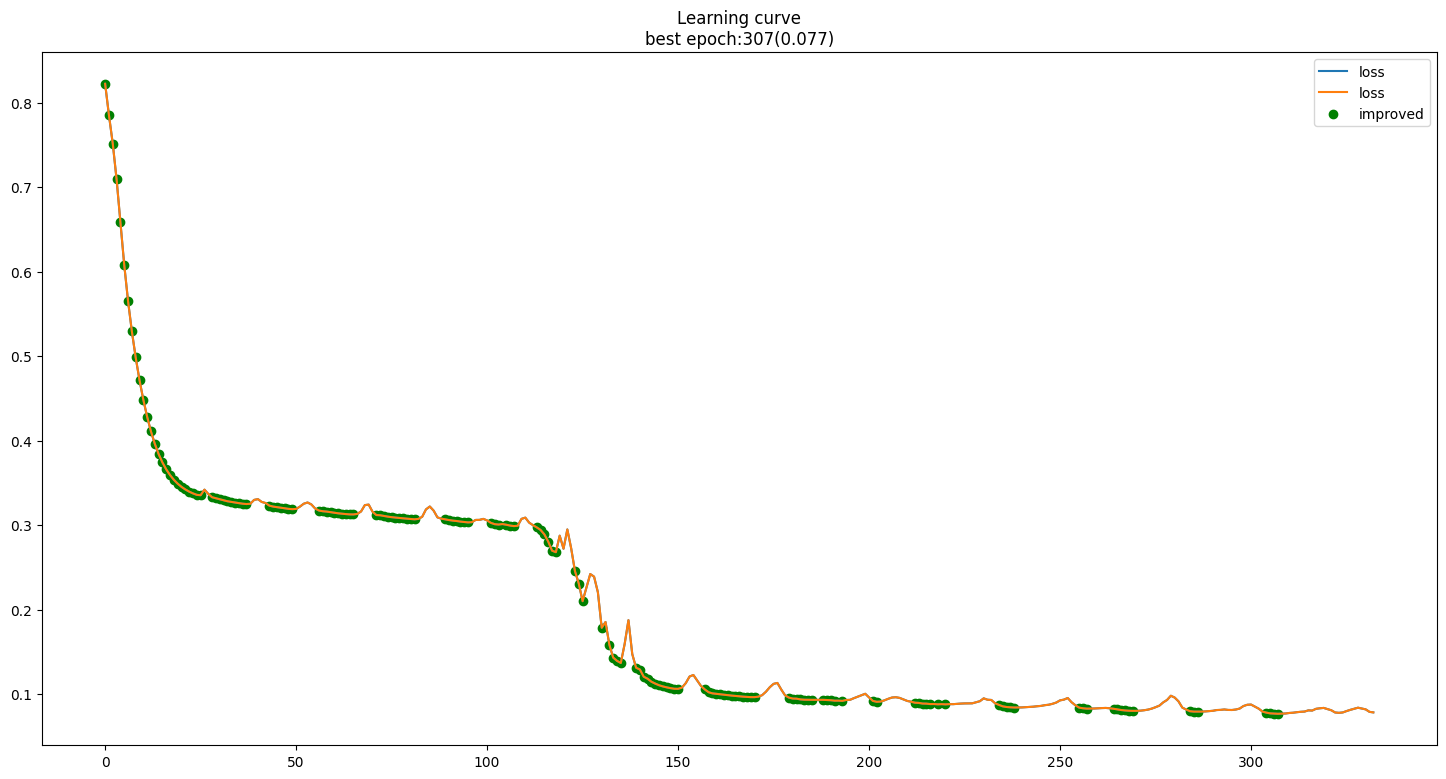

In [55]:
plot_learning_curve(history, monitor_label='loss')